In [60]:
!pip install pandas
!pip3 install taxoniq
!pip install seaborn


[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: pip install --upgrade pip


In [67]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import taxoniq # https://github.com/taxoniq/taxoniq

In [68]:
'''
1. X read in the csv file
2. X append human-readable taxon names
3. X fix the weirdness of bases in the two columns (to get maximum of total_sequence_length and total_alignment_length)
4. X get the proportion of *post-subsampled bases* that map to each taxid
5. X get the percentage of *total bases* that map to each taxid (requires some proportion estimation)
6. X plot the relative abundance of species
7. make a new dataframe with all the samples from one experiment
8. plot a heatmap of the relative abundance of species in each sample
'''

'\n1. X read in the csv file\n2. X append human-readable taxon names\n3. X fix the weirdness of bases in the two columns (to get maximum of total_sequence_length and total_alignment_length)\n4. X get the proportion of *post-subsampled bases* that map to each taxid\n5. X get the percentage of *total bases* that map to each taxid (requires some proportion estimation)\n6. X plot the relative abundance of species\n7. make a new dataframe with all the samples from one experiment\n8. plot a heatmap of the relative abundance of species in each sample\n'

In [88]:
# set the input file names
nt_hits_filepath = "zymobiomics/tallied_hits_nt.csv"
subsampled_base_count_filepath = "zymobiomics/subsampled_bases.count"
human_filter_base_count_filepath = "zymobiomics/human_filtered_bases.count"
input_base_count_filepath = "zymobiomics/validated_bases.count"

In [89]:
# read in nt hits data using pandas
nt_hits_df = pd.read_csv(nt_hits_filepath)
nt_hits_df.head()

,taxid,level,total_sequence_length,total_alignment_length
0,287,species,29542413,6589714
1,286,genus,29542413,6589714
2,562,species,66353767,4859230
3,561,genus,66353767,4859230
4,590,genus,99265591,4553287


In [90]:
# test taxoniq
t = taxoniq.Taxon(9606)
t.scientific_name

'Homo sapiens'

In [91]:
# Task #2 -- append human-readable taxon names using taxoniq

# option #1 - full FOR loop
#scientific_name = []
#for i in nt_hits_df["taxid"]:
#    t = taxoniq.Taxon(i)
#    scientific_name.append(t.scientific_name)
#print(scientific_name)    
#nt_hits_df["scientific_name"] = scientific_name

# option #2 - using python list comprehension (similar to lapply in R)
nt_hits_df["scientific_name"] = [taxoniq.Taxon(i).scientific_name for i in nt_hits_df["taxid"]]

In [92]:
nt_hits_df.head()

,taxid,level,total_sequence_length,total_alignment_length,scientific_name
0,287,species,29542413,6589714,Pseudomonas aeruginosa
1,286,genus,29542413,6589714,Pseudomonas
2,562,species,66353767,4859230,Escherichia coli
3,561,genus,66353767,4859230,Escherichia
4,590,genus,99265591,4553287,Salmonella


In [93]:
# Task #3 -- fix the weirdness of bases in the two columns 
#            (get maximum of total_sequence_length and total_alignment_length)
nt_hits_df["total_bp"] = nt_hits_df[["total_sequence_length", "total_alignment_length"]].max(axis=1)

In [94]:
# Task #4 -- get the proportion of *post-subsampled bases* that map to each taxid
subsampled_count = int(open(subsampled_base_count_filepath, 'r').read())
print(subsampled_count)

# NOTE: this is the proportion of non-host reads
nt_hits_df["proportion_of_subsampled"] = nt_hits_df["total_bp"].divide(subsampled_count)

341818262


In [95]:
# Logic for Task #5 -- brainstorming how we need to compute the % of total bp
'''
scaling-factor = bp-before-subsampling / bp-after-subsampling = 1000000/500000 = 2 
taxid-count = 10000 bp to sars-cov-2
non-subsampled-taxid-bp-count = scaling-factor * taxid-count
'''

'\nscaling-factor = bp-before-subsampling / bp-after-subsampling = 1000000/500000 = 2 \ntaxid-count = 10000 bp to sars-cov-2\nnon-subsampled-taxid-bp-count = scaling-factor * taxid-count\n'

In [96]:
# Task #5 -- get the percentage of *total bases* that map to each taxid (requires some proportion estimation)

# read in the human_filter_count (because this is the step right before subsampling)
human_filter_count = int(open(human_filter_base_count_filepath, 'r').read())
print(human_filter_count)

scaling_factor = human_filter_count / subsampled_count
print(scaling_factor)

# compute scaling-factor adjusted bp counts
nt_hits_df["total_bp_adjusted"] = nt_hits_df["total_bp"].multiply(scaling_factor)

# read in the total initial bp (from validate_input step)
# NOTE: KK realized that this is the incorrect number! we actually need to separately get the
#       total input bp. I pinged Todd about this here: https://czi-sci.slack.com/archives/C03VBBX15UY/p1666213389472059
#       but we can generate this offline for the samples you've already run
total_initial_bp = int(open(input_base_count_filepath, 'r').read())
print(total_initial_bp)

# NOTE: this is proportion of total reads
nt_hits_df["proportion_total_bp_adjusted"] = nt_hits_df["total_bp_adjusted"].divide(total_initial_bp)

27698301682
81.03224655094643
28163994969


In [97]:
# separate out the dataframes into genus and species level and write to output csv

genus_nt_hits = nt_hits_df[nt_hits_df.level == "genus"]
genus_nt_hits.to_csv("zymbiomics_genus_nt_hits.csv")

species_nt_hits = nt_hits_df[nt_hits_df.level == "species"]
species_nt_hits.to_csv("zymbiomics_species_nt_hits.csv")

In [98]:
nt_hits_df


,taxid,level,total_sequence_length,total_alignment_length,scientific_name,total_bp,proportion_of_subsampled,total_bp_adjusted,proportion_total_bp_adjusted
0,287,species,29542413,6589714,Pseudomonas aeruginosa,29542413,8.642725e-02,2.393888e+09,8.499817e-02
1,286,genus,29542413,6589714,Pseudomonas,29542413,8.642725e-02,2.393888e+09,8.499817e-02
2,562,species,66353767,4859230,Escherichia coli,66353767,1.941200e-01,5.376795e+09,1.909102e-01
3,561,genus,66353767,4859230,Escherichia,66353767,1.941200e-01,5.376795e+09,1.909102e-01
4,590,genus,99265591,4553287,Salmonella,99265591,2.904046e-01,8.043714e+09,2.856027e-01
5,28901,species,99265591,4553287,Salmonella enterica,99265591,2.904046e-01,8.043714e+09,2.856027e-01
6,1386,genus,24767698,3978051,Bacillus,24767698,7.245867e-02,2.006982e+09,7.126057e-02
7,1423,species,22638371,3456069,Bacillus subtilis,22638371,6.622926e-02,1.834438e+09,6.513416e-02
8,4930,genus,78855,3223040,Saccharomyces,3223040,9.429104e-03,2.611702e+08,9.273193e-03
9,4932,species,78855,3147631,Saccharomyces cerevisiae,3147631,9.208493e-03,2.550596e+08,9.056230e-03


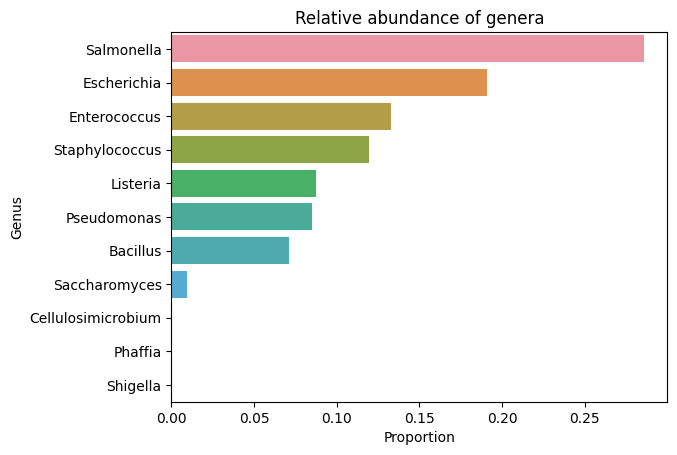

In [124]:
#Sort species by propotion of total adjusted bases to show the top species IDs
genus_nt_hits.sort_values(by='proportion_total_bp_adjusted', ascending=False).head()
sns.barplot(x = 'proportion_total_bp_adjusted', y = 'scientific_name', data = genus_nt_hits, order = genus_nt_hits.sort_values(by='proportion_total_bp_adjusted', ascending=False).scientific_name)
plt.ylabel('Genus')
plt.xlabel('Proportion')
plt.title('Relative abundance of genera')
plt.savefig('genera_relative_abund.png', dpi=200, bbox_inches = 'tight')

In [103]:
#Sort species by propotion of total adjusted bases to show the top species IDs
species_nt_hits.sort_values(by='proportion_total_bp_adjusted', ascending=False).head()


,taxid,level,total_sequence_length,total_alignment_length,scientific_name,total_bp,proportion_of_subsampled,total_bp_adjusted,proportion_total_bp_adjusted
5,28901,species,99265591,4553287,Salmonella enterica,99265591,0.290405,8.043714e+09,0.285603
2,562,species,66353767,4859230,Escherichia coli,66353767,0.194120,5.376795e+09,0.190910
15,1351,species,46096271,2161906,Enterococcus faecalis,46096271,0.134856,3.735284e+09,0.132626
13,1280,species,41324359,2222331,Staphylococcus aureus,41324359,0.120896,3.348606e+09,0.118897
10,1639,species,30471044,2521431,Listeria monocytogenes,30471044,0.089144,2.469137e+09,0.087670


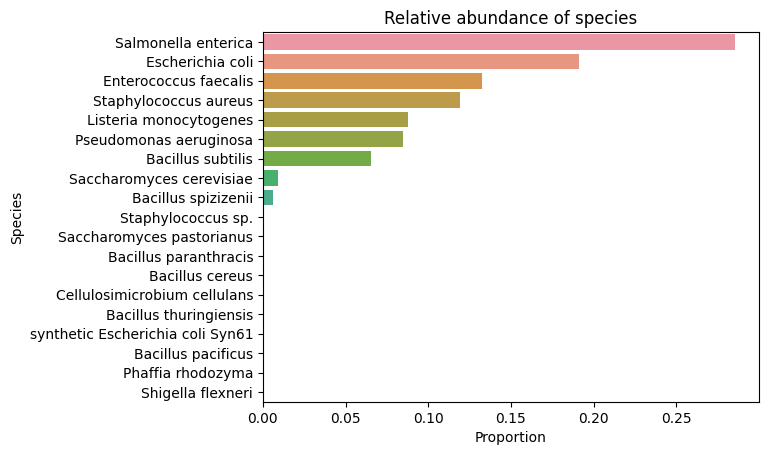

In [123]:
# Plot the relative abundance of species
sns.barplot(x = 'proportion_total_bp_adjusted', y = 'scientific_name', data = species_nt_hits, order = species_nt_hits.sort_values(by='proportion_total_bp_adjusted', ascending=False).scientific_name)
plt.ylabel('Species')
plt.xlabel('Proportion')
plt.title('Relative abundance of species')
plt.savefig('species_relative_abund.png', dpi=200, bbox_inches = 'tight')